In [ ]:
# %matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
# get to know the start position and number of segments for each drilling file
file_indice="../data/dataset/drilling_layers/largesize/Drilling_layers_indice_part.csv"
df= pd.read_csv(file_indice, header=None)
df.columns= ['start_seg', 'nb_segs']
start_segs= df['start_seg'].values
nb_segs= df['nb_segs'].values
# df.head(5)

from data_processing import data_loading, data_cutoff, train_data_prepare

file_data_base= "../data/dataset/drilling_layers/largesize/Drilling_layers_"
file_label_base= "../data/dataset/drilling_layers/largesize/Pulse_label_"

vol_all=np.empty((0, 200))
cur_all=np.empty((0, 200))
labels_all=np.empty((0, 1))
for i in range(0, 5, 1):
    file_data= file_data_base + str((i+1)*10) + ".tdms"
    file_label= file_label_base + str((i+1)*10) + ".csv"
    
    vol, cur, labels= data_loading(file_data, file_label,
                            start_seg=start_segs[i], nb_segs= nb_segs[i])
    vol_all=   np.concatenate((vol_all, vol), axis=0)
    cur_all=   np.concatenate((cur_all, cur), axis=0)
    labels_all=np.concatenate((labels_all, labels), axis=0)
    del vol, cur, labels

number_to_cutoff=[1700000, 100000]
# cut off some OC and NC pulses for dataset balance
vol_all, cur_all, labels_all= data_cutoff(vol_all, cur_all, labels_all, number_to_cutoff=number_to_cutoff)

# train and validate split
X_train, y_train, X_val, y_val, n_features, n_timesteps, n_classes= train_data_prepare(
    vol_all, cur_all, labels_all
)

Good! we now have 265000 number of pulses!
We have retrieved 265000 pulses!
Good! we now have 281000 number of pulses!
We have retrieved 281000 pulses!
Good! we now have 455000 number of pulses!
We have retrieved 455000 pulses!
Good! we now have 516000 number of pulses!
We have retrieved 516000 pulses!
Good! we now have 668000 number of pulses!
We have retrieved 668000 pulses!
feature dimension: 2
time steps: 200
number of classes: 6
train size: 308000; validation size: 77000


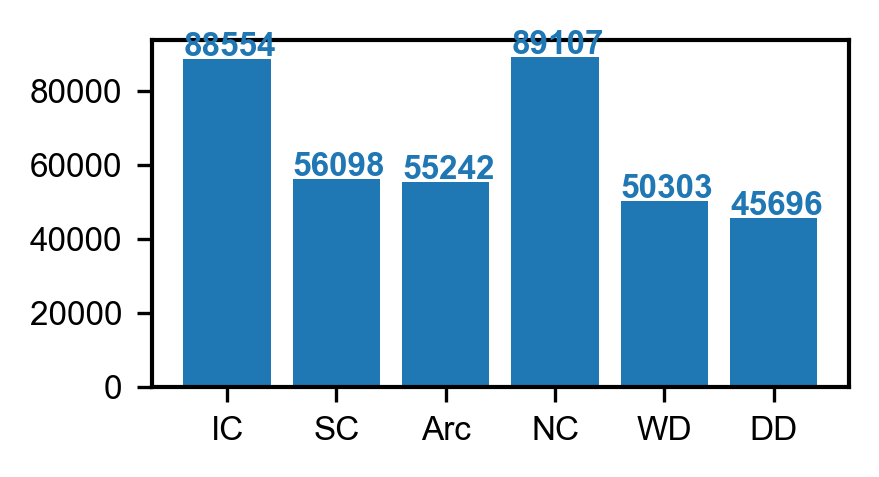

In [ ]:
label_names=['IC', 'SC', 'Arc', 'NC', 'WD', 'DD']

counts=[]
for i in range(len(label_names)):
    counts.append(np.count_nonzero(labels_all[:]==i))

import matplotlib
matplotlib.rcParams.update({'font.size': 8})
matplotlib.rcParams["font.family"] = "Arial"
matplotlib.rcParams.update({'axes.linewidth': 1})

fig = plt.figure(figsize=(3, 1.5), dpi=300)
plt.bar(label_names, counts)
for i, v in enumerate(counts):
    plt.text(i-0.4, v+800, str(v), color='tab:blue', fontweight='bold')

In [4]:
# !!IF we want to use tensorflow dataset
#  This may slightly imporve the training performance
# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train), )
train_dataset = train_dataset.shuffle(buffer_size=4000000).batch(512, drop_remainder=True)
print(train_dataset.element_spec)
# Prepare the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(2048, drop_remainder=True)
print(val_dataset.element_spec)

del X_train,y_train,X_val,y_val

(TensorSpec(shape=(512, 200, 2), dtype=tf.float32, name=None), TensorSpec(shape=(512, 6), dtype=tf.uint8, name=None))
(TensorSpec(shape=(2048, 200, 2), dtype=tf.float32, name=None), TensorSpec(shape=(2048, 6), dtype=tf.uint8, name=None))


In [6]:
# If using GPU....
import os

# point out which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="0"
# limit the usage of GPU
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.95)
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.95, allow_growth=True)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

In [ ]:
from pc_tcn import build_tcn_v4, build_tcn_v5

# mdl= build_tcn_v4(n_timesteps, n_features, n_classes=n_classes, 
#                 n_units=16, k_size=5, dilation=(1,2,4,8,16), n_stacks=1,
#                 isMdlPlot=True)

mdl= build_tcn_v5(n_timesteps, n_features, n_classes=n_classes, 
                n_units=16, k_size=5, dilation=(1,2,4,8,16), n_stacks=1,dropout=0.5,
                activation_type='relu', norm_type='layer_norm', trasit_type='slice_last',
                isMdlPlot=True)

In [ ]:
from pc_lstm_residual import build_residual_lstm_v5

# mdl= build_residual_lstm_v3(n_timesteps, n_features, n_units=16, n_layers=1, n_classes=n_classes,
#                       isDropout=True)
mdl= build_residual_lstm_v5(n_timesteps, n_features, n_classes=n_classes,
                            n_units=16, n_layers=1, dropout=0.5,
                            activation_type='relu', norm_type='layer_norm', trasit_type='attention',
                            isMdlPlot=True)

In [ ]:
from tensorflow import keras
import os

workdir= '../data/model/tcn'
check_path=os.path.join(workdir, 'checkpoint')
log_dir= os.path.join(workdir, 'logs')

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
             keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5),
            #  keras.callbacks.ModelCheckpoint(filepath=check_path, monitor='val_accuracy',save_best_only=True),
            #  keras.callbacks.TensorBoard(log_dir=log_dir)
            ]

mdl.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
            loss=tf.keras.losses.CategoricalCrossentropy(), 
            metrics=['accuracy'])

# training using tensorflow dataset
history = mdl.fit(train_dataset, validation_data=val_dataset,
                epochs=100,
                callbacks=callbacks)

Epoch 1/100
601/601 [==============================] - 164s 223ms/step - loss: 1.2101 - accuracy: 0.5474 - val_loss: 0.8525 - val_accuracy: 0.6869
Epoch 2/100
601/601 [==============================] - 135s 223ms/step - loss: 0.8233 - accuracy: 0.6900 - val_loss: 0.6994 - val_accuracy: 0.7353
Epoch 3/100
601/601 [==============================] - 136s 226ms/step - loss: 0.7140 - accuracy: 0.7271 - val_loss: 0.6495 - val_accuracy: 0.7469
Epoch 4/100
601/601 [==============================] - 137s 227ms/step - loss: 0.6606 - accuracy: 0.7442 - val_loss: 0.6075 - val_accuracy: 0.7606
Epoch 5/100
601/601 [==============================] - 139s 230ms/step - loss: 0.6250 - accuracy: 0.7541 - val_loss: 0.5781 - val_accuracy: 0.7690
Epoch 6/100
601/601 [==============================] - 136s 225ms/step - loss: 0.5996 - accuracy: 0.7611 - val_loss: 0.5556 - val_accuracy: 0.7761
Epoch 7/100
601/601 [==============================] - 136s 226ms/step - loss: 0.5812 - accuracy: 0.7674 - val_loss: 0

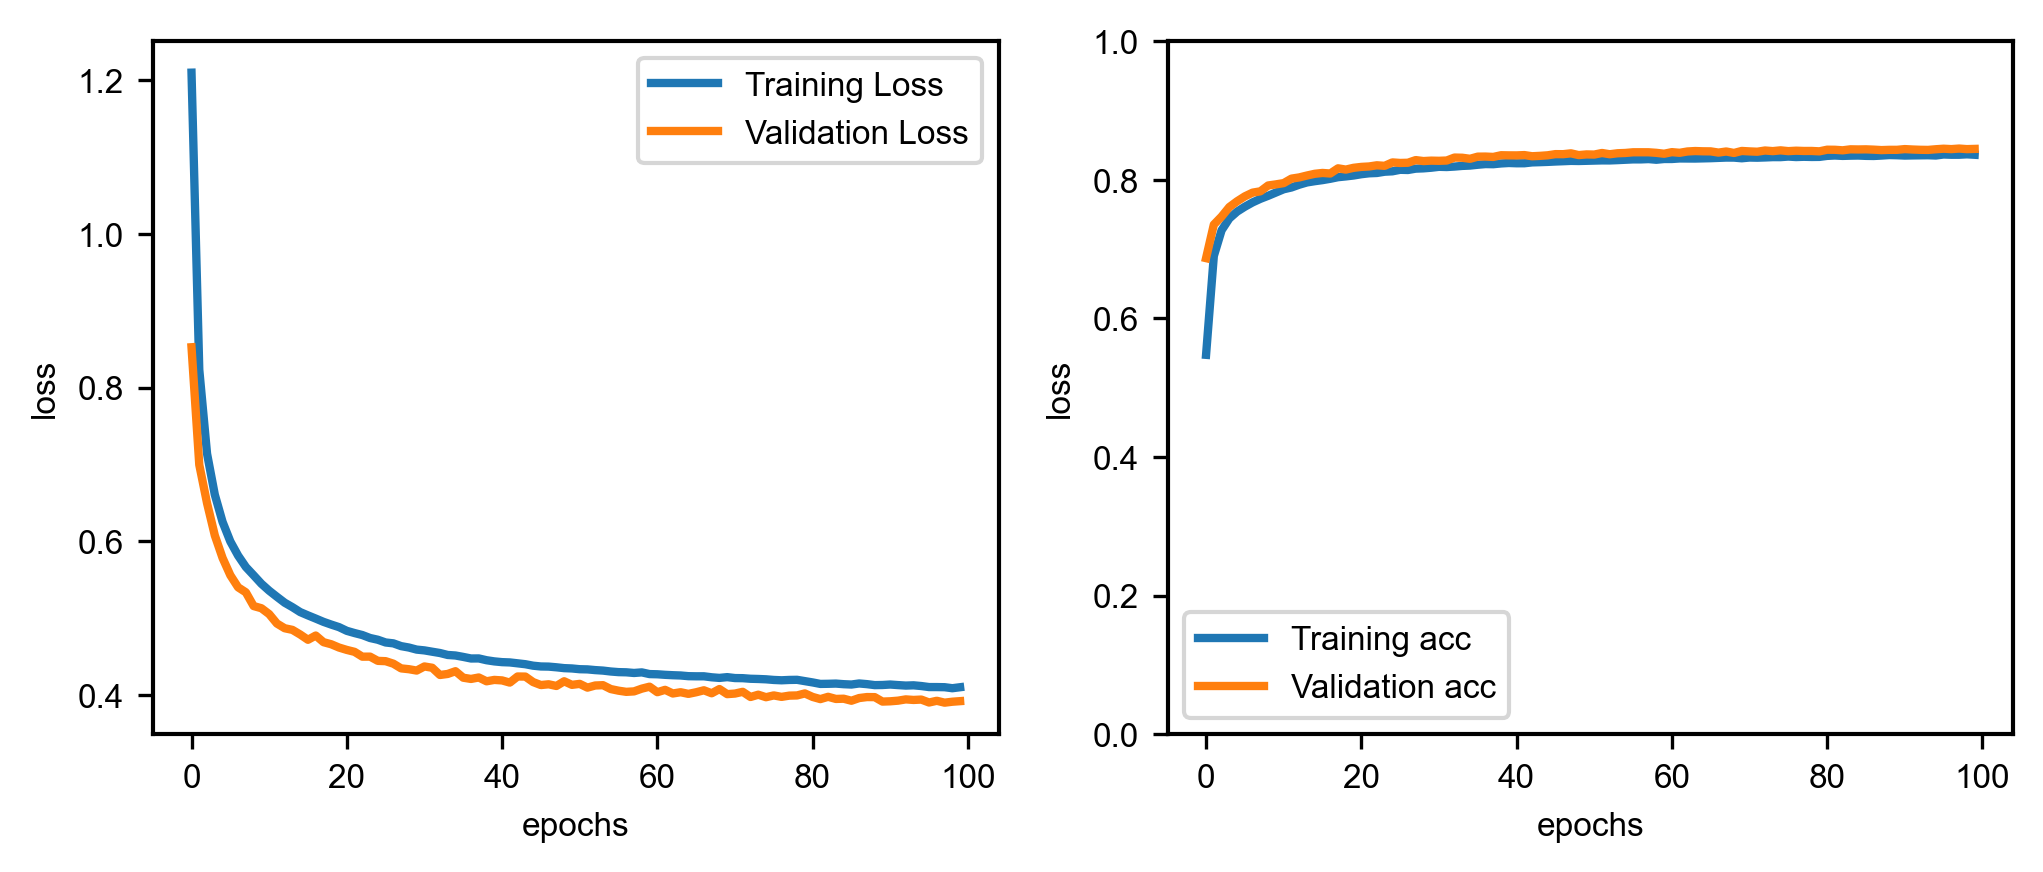

In [9]:
import matplotlib
matplotlib.rcParams.update({'font.size': 8})
matplotlib.rcParams["font.family"] = "Arial"
matplotlib.rcParams.update({'axes.linewidth': 1})

fig, ax= plt.subplots(1,2, figsize=(8,3), dpi=300)
ax[0].plot(history.history["loss"], linewidth=2, label="Training Loss")
ax[0].plot(history.history["val_loss"], linewidth=2, label="Validation Loss")
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('loss')
# ax[0].set_ylim([0, 1])
ax[0].legend()
ax[1].plot(history.history["accuracy"], linewidth=2, label="Training acc")
ax[1].plot(history.history["val_accuracy"], linewidth=2, label="Validation acc")
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('loss')
ax[1].set_ylim([0, 1])
ax[1].legend()

In [ ]:
# save the trained model
mdl.save("../data/model/tcn/comparison/mdl_tcn_v8.h5") # save
# mdl.save("../data/model/lstm/comparison/mdl_bilstm_v7.h5") # save

# save the history
import pickle
with open('../data/model/tcn/comparison/history_tcn_v8.h5', 'wb') as file_pi:
# with open('../data/model/lstm/comparison/history_bilstm_v7.h5', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)